## Imports

In [1]:
from datasets import load_dataset
import pandas as pd
import numpy as np

from tqdm import tqdm

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tensorflow import keras
from keras import layers
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from imblearn.over_sampling import SMOTE

## 1. Create test and set objects

In [2]:
dataset = load_dataset('gnad10')

Found cached dataset gnad10 (C:/Users/tomas/.cache/huggingface/datasets/gnad10/default/1.1.0/3a8445be65795ad88270af4d797034c3d99f70f8352ca658c586faf1cf960881)


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
df_train = dataset['train']
df_test = dataset['test']

df = pd.concat([pd.DataFrame(df_train), pd.DataFrame(df_test)], axis=0)

In [4]:
train_texts, test_texts, train_labels, test_labels = train_test_split(df['text'], df['label'], test_size=0.2, stratify=df['label'])

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# train_texts = df_train['text']
# #train_labels = np.array(df_train['label'])
# train_labels = to_categorical(np.array(df_train['label']), num_classes=9)
# test_texts = df_test['text']
# #test_labels = np.array(df_test['label'])
# test_labels = to_categorical(np.array(df_test['label']), num_classes=9)

# 2. Tokenize texts and remove stop words

In [5]:
nltk.download('stopwords')
stop_words = set(stopwords.words('german'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tomas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
train_tokenized = [word_tokenize(text) for text in tqdm(train_texts, desc='Train tokenization')]
test_tokenized = [word_tokenize(text) for text in tqdm(test_texts, desc='Test tokenization')]

Test tokenization: 100%|██████████| 2055/2055 [00:08<00:00, 243.34it/s]


In [7]:
train_filtered = [[token for token in text if token.lower() not in stop_words] for text in tqdm(train_tokenized, desc='Removing stop words')]
test_filtered = [[token for token in text if token.lower() not in stop_words] for text in tqdm(test_tokenized, desc='Removing stop words')]

Removing stop words: 100%|██████████| 2055/2055 [00:00<00:00, 8638.65it/s]


# 3. Vectorize and pad data

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)
train_sequences = tokenizer.texts_to_sequences(train_filtered)
test_sequences = tokenizer.texts_to_sequences(test_tokenized) # test_filtered

In [9]:
length_train = [len(token_list) for token_list in train_sequences]
SEQUENCE_LENGTH = int(np.quantile(length_train, 0.75))
SEQUENCE_LENGTH

265

In [10]:
train_data = pad_sequences(train_sequences, maxlen=SEQUENCE_LENGTH)
test_data = pad_sequences(test_sequences, maxlen=SEQUENCE_LENGTH)

# 4. Do SMOTE and reweighting

In [11]:
smote = SMOTE()
train_data, train_labels = smote.fit_resample(train_data, train_labels)

In [12]:
from collections import Counter
class_counts = Counter(train_labels)
samples = sum(class_counts.values())
class_weights = {}
for label, count in class_counts.items():
    class_weights[label] = (1 / count) * (samples / len(class_counts))

print(f'class weights:\n {class_weights}')

class weights:
 {3: 1.0, 0: 1.0, 6: 1.0, 8: 1.0, 7: 1.0, 5: 1.0, 4: 1.0, 2: 1.0, 1: 1.0}


In [13]:
print(f'shape of train texts: {train_data.shape}\n'
      f'shape of train labels: {train_labels.shape}\n'
      f'shape of test texts: {test_data.shape}\n'
      f'shape of test labels: {test_labels.shape}')

shape of train texts: (12078, 265)
shape of train labels: (12078,)
shape of test texts: (2055, 265)
shape of test labels: (2055,)


# 5. Create a model

In [14]:
VOCAB_LENGTH = len(tokenizer.word_index) + 1
VECTOR_SIZE = 100

def get_model():

      """
      model.add(layers.Conv1D(filters=32, kernel_size=3, activation='relu'))
      model.add(layers.MaxPooling1D(pool_size=2))

      model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
      model.add(layers.MaxPooling1D(pool_size=2))

      model.add(layers.Flatten())
      model.add(layers.Dense(units=128, activation='relu'))
      model.add(layers.Dropout(rate=0.5))
      model.add(layers.Dense(units=9, activation='softmax'))

      model.add(layers.Conv1D(32, 7, activation='relu'))
      model.add(layers.MaxPooling1D(2))
      model.add(layers.Dropout(0.5))

      model.add(layers.Conv1D(64, 5, activation='relu'))
      model.add(layers.MaxPooling1D(2))
      model.add(layers.Dropout(0.5))

      model.add(layers.Conv1D(128, 3, activation='relu'))
      model.add(layers.GlobalMaxPooling1D())
      model.add(layers.Dropout(0.5))
      """

      model = keras.Sequential()
      model.add(layers.Embedding(input_dim=VOCAB_LENGTH, output_dim=VECTOR_SIZE, input_length=SEQUENCE_LENGTH))

      # model.add(layers.Conv1D(128, 5, activation='relu'))
      # model.add(layers.GlobalMaxPooling1D())
      #
      # model.add(layers.Dense(64, activation='relu'))
      # model.add(layers.Dropout(0.5))

      model.add(layers.Conv1D(filters=256, kernel_size=7, activation='relu'))
      model.add(layers.GlobalMaxPooling1D())
      model.add(layers.Dense(128, activation='relu'))
      model.add(layers.Dropout(0.5))

      model.add(layers.Dense(9, activation='softmax'))
      model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

      return model

In [15]:
model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 265, 100)          16693900  
                                                                 
 conv1d (Conv1D)             (None, 259, 256)          179456    
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 9)                 1161      
                                                        

# 5. Fit the model and show metrics

In [16]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')

In [17]:
history = model.fit(train_data, train_labels, validation_data=(test_data, test_labels), epochs=10, callbacks=[early_stop]) #class_weight=class_weights

Epoch 1/10
378/378 [==============================] - 122s 315ms/step - loss: 1.9619 - accuracy: 0.2621 - val_loss: 2.4682 - val_accuracy: 0.2477
Epoch 2/10
378/378 [==============================] - 119s 316ms/step - loss: 1.1410 - accuracy: 0.5903 - val_loss: 2.8581 - val_accuracy: 0.2929
Epoch 3/10
378/378 [==============================] - 114s 301ms/step - loss: 0.5260 - accuracy: 0.8218 - val_loss: 2.6162 - val_accuracy: 0.3523
Epoch 4/10
378/378 [==============================] - 116s 308ms/step - loss: 0.1626 - accuracy: 0.9536 - val_loss: 2.7337 - val_accuracy: 0.3966
Epoch 5/10
378/378 [==============================] - 111s 292ms/step - loss: 0.0538 - accuracy: 0.9877 - val_loss: 2.5729 - val_accuracy: 0.4579
Epoch 6/10
378/378 [==============================] - 108s 286ms/step - loss: 0.0299 - accuracy: 0.9941 - val_loss: 2.8858 - val_accuracy: 0.4209
Epoch 6: early stopping


In [18]:
test_loss, test_accuracy = model.evaluate(test_data, test_labels)

65/65 [==============================] - 3s 41ms/step - loss: 2.8858 - accuracy: 0.4209


# 6. Visualize metrics

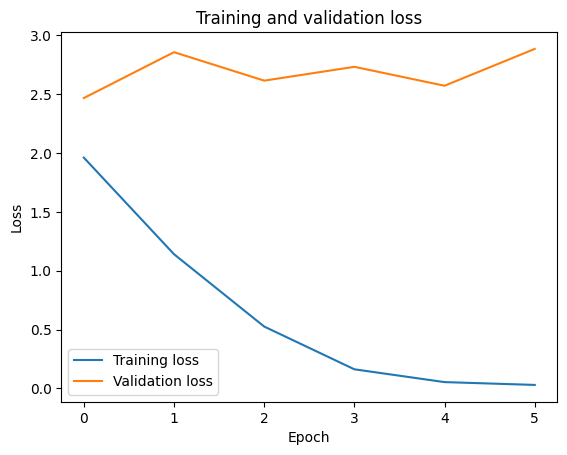

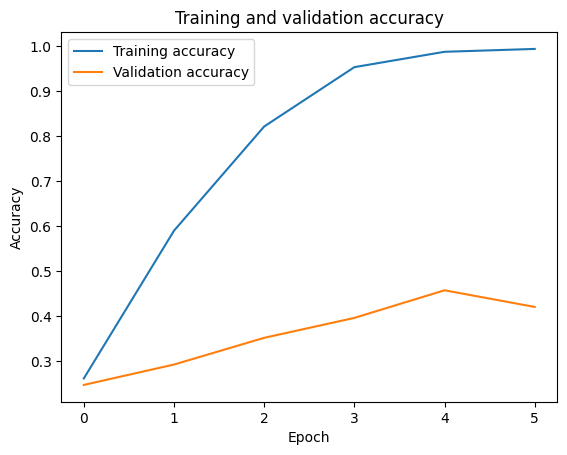

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()